# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. We split the data into two parts. One dataset containing the last 30 days and one dataset with the rest.

In [597]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

# read raw data
df_all = pd.read_csv('day.csv')
df_hourly = pd.read_csv('hour.csv')
window_size = 2  # window size for moving average of weather features
# split dataset

# We want to test the prediction model on the last 30 days, but since we are using moving averages
# of previous days (windowsize) as features, we need to include the last 30 + windowsize days in the test set and later drop
# the first rows.
# if window_size = 0, we do not need to do this and essentially rely on weather forecast

df_last30 = df_all.tail(30 + window_size)
df = df_all.iloc[:-30, :]

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


### 1. Steps to clean the data:
 - Check for missing feature values
 - Select relevant features, remove redundant features (features that yield no additional information)
 - Create dummy variables for categorial features, such as weathersit
 - Transform cyclic features using sine and cosine functions

In [598]:
# check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     701 non-null    int64  
 1   dteday      701 non-null    object 
 2   season      701 non-null    int64  
 3   yr          701 non-null    int64  
 4   mnth        701 non-null    int64  
 5   holiday     701 non-null    int64  
 6   weekday     701 non-null    int64  
 7   workingday  701 non-null    int64  
 8   weathersit  701 non-null    int64  
 9   temp        701 non-null    float64
 10  atemp       701 non-null    float64
 11  hum         701 non-null    float64
 12  windspeed   701 non-null    float64
 13  casual      701 non-null    int64  
 14  registered  701 non-null    int64  
 15  cnt         701 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 87.8+ KB


In [599]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,351.000000,2.479315,0.479315,6.285307,0.028531,3.004280,0.684736,1.385164,0.502732,0.480847,0.625717,0.190534,866.937233,3661.104137,4528.041369
std,202.505555,1.090839,0.499929,3.329294,0.166602,2.003207,0.464953,0.542489,0.182781,0.162584,0.141988,0.076740,693.470674,1553.467783,1939.766889
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,176.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.343478,0.348470,0.519167,0.134958,317.000000,2507.000000,3194.000000
50%,351.000000,2.000000,0.000000,6.000000,0.000000,3.000000,1.000000,1.000000,0.514167,0.503146,0.623750,0.182221,738.000000,3656.000000,4541.000000
75%,526.000000,3.000000,1.000000,9.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.613025,0.728750,0.233221,1135.000000,4739.000000,6041.000000
max,701.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Both data sets do not have features with missing values

In [ ]:
# select relevant features for prediction, exclude redundant features
# we include the number of rentals of the previous day as additional feature
# (under the assumption that the number of rentals each day is close to the previous day)

relevant_features = [# 'season',
                     'yr',
                     # 'mnth',
                     'holiday',
                     # 'weekday',
                     # 'workingday',
                     'weathersit',
                     'temp',
                     'atemp',
                     'hum',
                     'windspeed',
                     'mnth_sin',
                     'mnth_cos',
                     'weekday_sin',
                     'weekday_cos',
                     'season_sin',
                     'season_cos',
                     'cnt'
                    ]

# if window_size = 0, we can not use number of rentals of previous days
if window_size == 0:
    relevant_features.remove('cnt')

# encode cyclic features (month, weekday, season) using sine and cosine transformations
df.loc[:, 'mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
df.loc[:,'mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)
df.loc[:,'weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df.loc[:,'weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
df.loc[:,'season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
df.loc[:,'season_cos'] = np.cos(2 * np.pi * df['season'] / 4)
df_last30.loc[:,'mnth_sin'] = np.sin(2 * np.pi * df_last30['mnth'] / 12)
df_last30.loc[:,'mnth_cos'] = np.cos(2 * np.pi * df_last30['mnth'] / 12)
df_last30.loc[:,'weekday_sin'] = np.sin(2 * np.pi * df_last30['weekday'] / 7)
df_last30.loc[:,'weekday_cos'] = np.cos(2 * np.pi * df_last30['weekday'] / 7)
df_last30.loc[:,'season_sin'] = np.sin(2 * np.pi * df_last30['season'] / 4)
df_last30.loc[:,'season_cos'] = np.cos(2 * np.pi * df_last30['season'] / 4)


# categorical features to be one-hot encoded
# season is already encoded cyclically but could alternatively be one-hot encoded
categorical_features = [# 'season',
                        'weathersit'
                        ]

# prepare target vector and feature matric w.r.t. relevant features and one-hot encoding
# drop one column per categorical feature to avoid collinearity and reduce dimensionality
filtered_df = pd.get_dummies(df[relevant_features], columns=categorical_features, drop_first=True)
filtered_df_last30 = pd.get_dummies(df_last30[relevant_features], columns=categorical_features, drop_first=True)

# ensure both dataframes have the same columns after one-hot encoding
# features that are not present in the last 30 days will be filled with zeros
# features that are not present in the training set but in the test set will be ignored
filtered_df_last30 = filtered_df_last30.reindex(columns=filtered_df.columns, fill_value=0)

external_features = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# apply moving average to external features to avoid reliance on weather forecast or leakage of future data

drop_first = 0

# transform external features using moving average of previous days if window_size > 0
# otherwise we rely on weather forecast
if window_size > 0:

    for feature in external_features:
        filtered_df[feature] = df[feature].shift(1).rolling(window=window_size, min_periods=1).mean()
        filtered_df_last30[feature] = df_last30[feature].shift(1).rolling(window=window_size, min_periods=1).mean()

    # drop first row with NaN values due to moving average
    filtered_df = filtered_df.dropna().reset_index(drop=True)
    # drop first rows due to the we only want to predict the last 30 days instead of 30 + windowsize days
    filtered_df_last30 = filtered_df_last30.iloc[window_size:].reset_index(drop=True)
    drop_first = 1

# target vector (train and test)
count_vector = df['cnt'].iloc[drop_first:].reset_index(drop=True)
count_vector_last30 = df_last30['cnt'].iloc[window_size:].reset_index(drop=True)

Given the feature set, the information 'workday' is contained in the features 'weekday' and 'holiday' thus the feature 'workday' is redundant. 

### 2. Visualize rentals of bikes per day

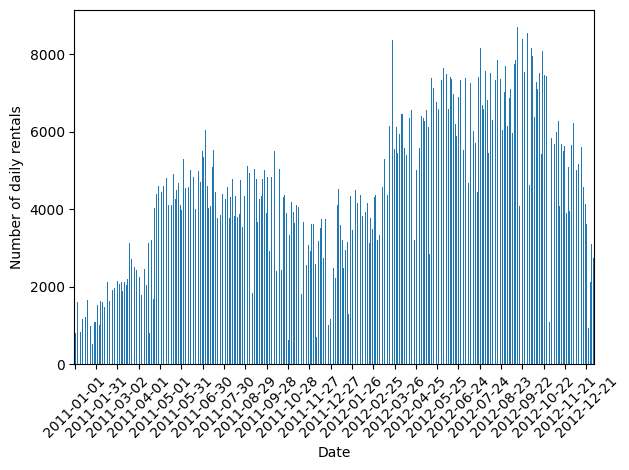

In [601]:
# plot the number of daily rentals as a bar chart
ax = df_all['cnt'].plot(kind='bar')
ax.set_xticks(range(0, len(df_all['dteday']), 30))
ax.set_xticklabels(df_all['dteday'][::30], rotation=45)
plt.ylabel('Number of daily rentals')
plt.xlabel('Date')
plt.tight_layout()
plt.show()
plt.close()

The plot shows a significant increase in daily rentals in 2012 compared to 2011. This might be due to a general growth of the business.

### 3. Find `nmax` and `n95`
- The naive approach to calculate the maximum numbers of required bikes per day would be to divide the total count per day by 12 (assuming maximum rentals of one bike is 12 per day). This approach ignores the possibility that, one bike cannot be rented multiple times within the same hour. Thus, if the maximum count per hour within one day exceeds the total count per day divided by 12, then the maximum count per hour becomes the maximum number of bikes needed for this day.

In [602]:
# check for missing values in hourly data set
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [603]:
df_hourly.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


The hourly data set does not contain empty values.

In [604]:
# Calculate two estimates for the minimum number of bikes needed per day
# the element-wise maximum becomes the final estimate per-day array
max_no_bikes = df_all['cnt']/12
max_no_parallel = df_hourly.groupby('dteday')['cnt'].max()
required_bikes_per_day = np.maximum(max_no_parallel.to_numpy(), np.ceil(max_no_bikes.to_numpy()))

In [605]:
# Calculate nmax by simply taking the maximum value of the required bikes per day array
nmax = np.max(required_bikes_per_day)
print(f'The maximum number of bikes required in any one day is {int(nmax)}.')

# Calculate n95 by selecting the 95th percentile of the ordered required bikes per day array
ordered_required_bikes = np.sort(required_bikes_per_day)
n95 = ordered_required_bikes[int(0.95*len(ordered_required_bikes))]

print(f'The number of bikes required to cover the demand in 95% of the days is {int(n95)}.')

The maximum number of bikes required in any one day is 977.
The number of bikes required to cover the demand in 95% of the days is 868.


### 4. Visualize the distribution of covered days as a function of the number of available bikes

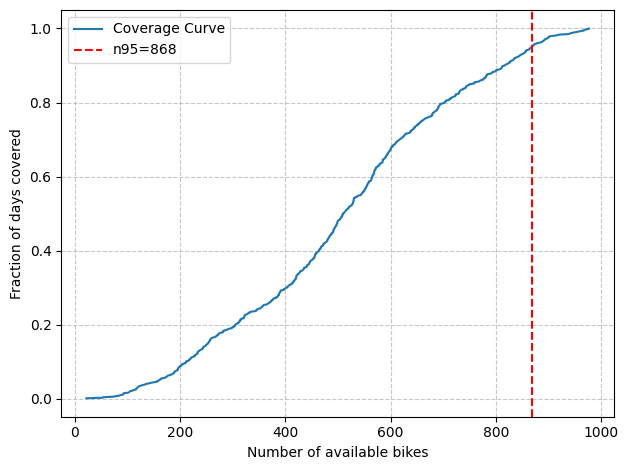

In [606]:
required_bikes_sorted = np.sort(required_bikes_per_day)
percentages = (np.arange(len(required_bikes_per_day)) + 1)/len(required_bikes_per_day)
plt.plot(required_bikes_sorted, percentages, label='Coverage Curve')
plt.axvline(n95, color='r', linestyle='--', label=f'n95={int(n95)}')
plt.xlabel('Number of available bikes')
plt.ylabel('Fraction of days covered')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.close()

In order to cover the demand of all days compared to 95 percent of the days, 109 additional bikes are required.

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

### 1. Define test metric for prediction models

In [607]:
# TODO: your code comes here

# Define test metric for prediction models as root mean squared error

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Include visual metric to evaluate prediction models
# Use a residual scatter plot to visualize the prediction quality

def residual_plot(y_true, y_pred_list, lables):
    
    for y_pred, label in zip(y_pred_list, lables):
        residuals = y_true - y_pred
        plt.scatter(y_true, residuals, alpha=0.5, label=label)

    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('True Count Values')
    plt.ylabel('Residual (Truth - Prediction)')
    plt.ylim(-6000, 6000)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()


### 2. Build random forest prediction model given the previously calculated target vector and feature matrix
- We use regular random forests as well as gradient boosted trees for comparison

In [622]:
# train random forest regressor (classic and gradient boosted)
classic_forest = sk.ensemble.RandomForestRegressor(n_estimators=1000)
classic_forest.fit(filtered_df, count_vector)
gradient_boosted_forest = sk.ensemble.GradientBoostingRegressor(n_estimators=1000)
gradient_boosted_forest.fit(filtered_df, count_vector)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,1000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


### 3. Test models on test data and report value of test metric
- We test our prediction models on the last 30 days of the original data set as they were not part of the training set.

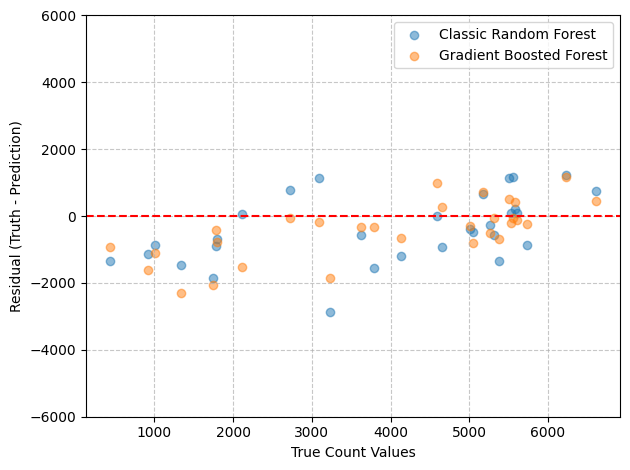

RMSE of Classic Random Forest: 1072.1908244560605
RMSE of Gradient Boosted Forest: 943.6838115400948


In [624]:
# Use random forest regrression models to predict the demand for the last 30 days of the data set
gradient_predicted = gradient_boosted_forest.predict(filtered_df_last30)
classic_predicted = classic_forest.predict(filtered_df_last30)

# Plot residuals of both models
residual_plot(count_vector_last30,
              [classic_predicted, gradient_predicted],
              ['Classic Random Forest', 'Gradient Boosted Forest'])

# Calculate and print RMSE for both models
classic_rmse = rmse(count_vector_last30, classic_predicted)
gradient_rmse = rmse(count_vector_last30, gradient_predicted)

print(f'RMSE of Classic Random Forest: {classic_rmse}')
print(f'RMSE of Gradient Boosted Forest: {gradient_rmse}')


Results of classic forest and gradient boosted forest are quite close.

## Part 4 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

- The suggested models were all trained on weather related features. Since these are only available only shortly in advance, the accuracy of the prediction model depends on the accuracy of the weather prediction. We trained the model with moving averages of the weather feature from previous days alternatively one could rely on weather forcasting which might be more accurate.
- If one wants to do long-term predictions (months in advance), then one would have to rely on only date related features (day and month) and ditch weather related features or rely on yearly averages of them. This would require the training set to cover multiple years in order to train a viable prediction model.
- As the total demand seems to be increasing year by year, a random forest has drawbacks in its prediction power for the coming years, since the maximum value of the model is limited by the training set and random forests are not suited for extrapolation.
- Other regression models (neural networks or linear models) could be better suited for extrapolation
- We already dropped features that are redundant, but through principal component analysis we can check for further redundant features to reduce the dimensionality of the problem. (There is a high chance that the felt temperature is derivable from the real temperature and the windspeed -> wind chill temperature.)
- Under the assumption that the number of rentals each day is close to the previous day, the number of rentals of the previous day was used as additional feature to improve performance
- Through hyper parameter optimization on the test set, we could find the optimal set of tree parameters to further minimize RMSE

Eigenvalues:
[0.00467084 0.07588785 0.09822339 0.13383707 0.22221556 0.64772595
 0.75328523 0.87684767 0.92621175 1.0437599  1.12877536 1.19837228
 1.45320099 2.10577336 4.33121281]


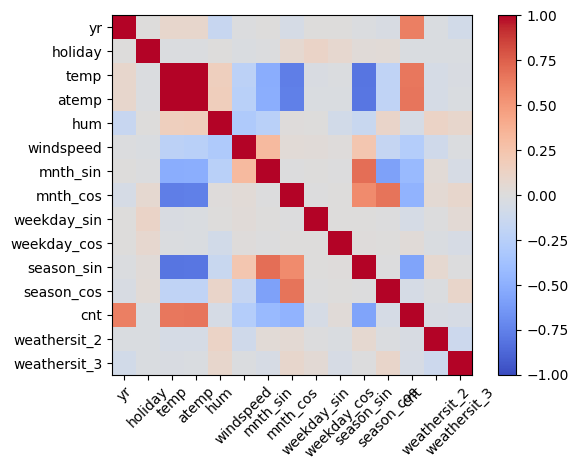

In [610]:
covariance = filtered_df.corr()
eigenvalues, eigenvectors = np.linalg.eig(covariance)
print('Eigenvalues:')
print(np.sort(eigenvalues))
im = plt.imshow(covariance, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(range(len(covariance.columns)), covariance.columns, rotation=45)
plt.yticks(range(len(covariance.columns)), covariance.columns)
plt.tight_layout()
plt.show()

- From the covariance plot, we can already observe that there is a strong correlation between the temperature and the felt temperature making one of them redundant.
- We can also observe that the total count correlates most with the seasons.

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.